<a href="https://www.kaggle.com/code/aisuko/generating-an-image-with-float16?scriptVersionId=164230621" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Overview

By default, the **DiffusionPipeline** runs inference with full **float32** precision for 50 inference steps. We can speed this up by switching to a lower precision like float16 or running fewer inference steps.

In [1]:
%%capture
!pip install diffusers==0.26.3
# ImportError: cannot import name 'CpuOffload' from 'accelerate.hooks'
!pip install transformers==4.38.1
!pip install accelerate==0.27.2
!pip install compel==2.0.2

In [2]:
import os
import torch
import warnings



os.environ['MODEL_NAME']='runwayml/stable-diffusion-v1-5'

if torch.cuda.is_available():
    torch_device = 'cuda'
else:
    torch_device = 'cpu'

warnings.filterwarnings('ignore')

print(torch_device)

cuda


## Loading models

In [3]:
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained(os.getenv('MODEL_NAME'), torch_dtype=torch.float16)
pipeline.to(torch_device)
print(pipeline)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.26.3",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}



## Generating

We use Compel to overcome 77 number of tokens limited.

torch.Size([1, 77, 768])
torch.Size([1, 77, 768])


  0%|          | 0/50 [00:00<?, ?it/s]

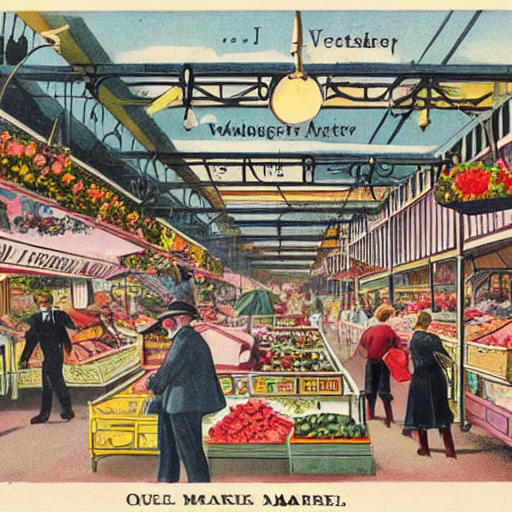

In [4]:
from compel import Compel

prompt = "A vintage postcard illustration of Melbourne's Queen Victoria Market, bustling with activity on a sunny Saturday morning. The stalls are overflowing with fresh fruits, vegetables, flowers, and local crafts. People of diverse backgrounds happily browse and shop, creating a vibrant and welcoming atmosphere. The iconic market buildings cast long shadows in the warm sunlight."
negative_prompt="ugly,low quality,Blurry or pixelated"

compel=Compel(tokenizer=pipeline.tokenizer, text_encoder=pipeline.text_encoder, truncate_long_prompts=False)
conditioning=compel.build_conditioning_tensor(prompt)
negative_conditioning=compel.build_conditioning_tensor(negative_prompt)

[con_embeds, neg_embeds] = compel.pad_conditioning_tensors_to_same_length([conditioning, negative_conditioning])

print(con_embeds.size())
print(neg_embeds.size())

generator = torch.Generator(device=torch_device).manual_seed(2024)
image = pipeline(prompt_embeds=con_embeds,negative_prompt_embeds=neg_embeds, generator=generator).images[0]
image